## Топ-50 наиболее частотных слов

Программа скачивает тексты новостных статей с сайта google news (https://news.google.com)<br>
(язык и регион - English | United States) с ключевым словом Russia за определенный период времени (на момент запуска).<br>
Период времени устанавливается переменной days (в днях).<br>
Для полученных текстов рассчитывает топ-50 наиболее частотных слов и представляет их в виде Word Cloud графики.<br>
Результат графики Word Cloud сохраняется в файл `result.png`.<br>
В файле `oval.png` содержится маска для формирования объекта WordCloud необходимой формы.<br>

#### Подключение библиотек

In [1]:
import requests
import time
import sys
import re
import collections
import matplotlib
import numpy as np
from PIL import Image
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#### Определение функций

In [2]:
def get_html(url, q_params={}):
    """Принимает на вход URL и параметры запроса. Возвращает html запрашиваемой страницы, либо None при ошибке соединения"""
    try:
        r = requests.get(url, params = q_params, headers=headers)
    except requests.exceptions.RequestException:
        print(' connection error')    # вывод сообщения, если ответ не получен
        if url == url_main:    # завершение программы, если не получен ответ от "главной" страницы 
            raise SystemExit('Incorrect url_main!')
        return
    return r.text


def get_inner_links(html, days):
    """Принимает на вход html "главной" страницы и период времени (в днях).
    Возвращает список внутренних ссылок на новостные статьи за заданный период времени."""
    print('Getting inner links...')
    links_list_final = []    # список внутренних ссылок, удовлетворяющих периоду времени
    soup = BeautifulSoup(html, 'html.parser')    # объект soup
    links_list = soup.findAll(class_='VDXfz')    # список всех внутренних ссылок на статьи
    time_list = soup.findAll(class_ = 'WW6dff')    # список POSIX-времен публикаций найденных статей (str)
    for i in range(len(time_list)):
        time_list[i] = int(time_list[i]['datetime'].partition(' ')[2].strip())    # определение времени публикации в секундах
    now = time.time()    # текущее POSIX-время
    for i in range(len(time_list)):    # формирование списка ссылок, удовлетворяющих периоду времени
        if now - time_list[i] <= days * 24 * 3600:
            links_list_final.append(url + links_list[i]['href'][1:])      
    print('Total inner links :', len(links_list))    # общее кол-во найденных внутренних ссылок
    print('Links in', days, 'days :', len(links_list_final))    # кол-во ссылок, удовлетворяющих периоду времени
    return links_list_final


def get_outer_links(inner_links_list):
    """Принимает на вход список внутренних ссылок. Возвращает список внешних ссылок."""  
    print("Getting outer links...")
    outer_links_list = []    # список внешних ссылок
    html_list = get_html_list(inner_links_list)    # список html страниц внутренних ссылок
    for i in html_list:
        soup = BeautifulSoup(i, 'lxml')    # объект soup
        soup = soup.find('div', attrs={'class' : 'm2L3rb'}).find('a').get_text()    # поиск внешней ссылки на статью
        outer_links_list.append(soup)    # добавление внешней ссылки в список
    print('Total outer links :', len(outer_links_list))    # кол-во полученных внешних ссылок
    return outer_links_list


def get_html_list(links_list):
    """Принимает список сылок. Возвращает список html страниц"""
    html_list = []    # список html страниц
    print('Getting HTML list...')
    for i in range(len(links_list)):
        html = get_html(links_list[i])    # получение html для каждой ссылки
        if html is None:    # переход к следующей итерации цикла, если html не получен 
            continue
        html_list.append(html)    # добавление полученного html к списку
        sys.stdout.write("\r%d/%d" % (i+1, len(links_list)))    # вывод прогресса выполнения в консоль
        sys.stdout.flush()    # очистка вывода
    print("\nTotal HTML's :", len(html_list))    # итоговое кол-во полученных html
    return html_list


def get_text_from_html(html):
    """Принимает на вход html страницы. Возвращает текст статьи с этой страницы."""
    article_text = ''    # текст статьи
    soup = BeautifulSoup(html, 'lxml')    # объект soup
    for i in soup(["script", "style", "figure", "footer"]):    # удаление скриптов, объектов style и figure из html
        i.decompose() 
    itemprop_list = soup.findAll(attrs={'itemprop' : 'articleBody'})    # список объектов с аттр. 'itemprop' : 'articleBody'
    if itemprop_list:    # если объекты itemprop найдены, забираем из них текст
        for i in itemprop_list:
            article_text += ' ' + i.get_text()
        return article_text
    else:    # если нет, ищем все объекты по тегу p и забираем текст из них
        paragraph_list = soup.findAll('p')
        for p in paragraph_list:
            article_text += ' ' + p.get_text()    # конкатенируем найденные параграфы, формируем текст статьи
    return article_text


def get_words_list(text_list):
    """Принимает на вход список текстов статей. Возвращает список слов всех статей."""
    for i in range(len(text_list)):      
        text_list[i] = text_list[i].lower()    # перевод текста статьи в нижний регистр
        text_list[i] = re.split("[^a-z’'-]", text_list[i])    # разбиение текста статьи по любому символу, кроме (a-z’'-)       
        for k in range(len(text_list[i])):
            for s in ["'", "’", "-"]:    # удаление знаков апострофа, одиночной кавычки и дефиса на концах слов 
                text_list[i][k] = text_list[i][k].strip(s)      
        while '' in text_list[i]:
            text_list[i].remove('')    # удаление пустых символов, оставшихся после разбиения текста на слова
    words_list = sum(text_list, [])    # разворачивание списка (убирает вложенные списки)
    print('Total words :', len(words_list))    # итоговое количество слов в списке текстов
    return words_list

#### Инициализация переменных

In [3]:
url = 'https://news.google.com'    # URL google news (понадобится при переходе от внутренних ссылок к внешним)
url_main = 'https://news.google.com/search'    # URL главной страницы
payload = {'q': 'Russia', 'ceid' : 'US:en'}     # параметры запроса {'q' : 'ключевое слово', 'ceid' : 'регион:язык'}
days = 30    # временной интервал в днях, за который необходимо скачать новостные статьи
headers = {'User-Agent': UserAgent().chrome}    # заголовочный файл, для имитации запроса через браузер

#### html главной страницы

In [4]:
html_main = get_html(url_main, payload)

#### Список внутренних ссылок

In [5]:
inner_links = get_inner_links(html_main, days)

Getting inner links...
Total inner links : 103
Links in 30 days : 101


#### Список внешних ссылок

In [6]:
outer_links = get_outer_links(inner_links)

Getting outer links...
Getting HTML list...
101/101
Total HTML's : 101
Total outer links : 101


#### Список html по внешним ссылкам

In [7]:
html_list = get_html_list(outer_links)

Getting HTML list...
101/101
Total HTML's : 101


#### Список текстов статей

In [8]:
text_list = []    # список текстов статей
print('Getting text list...')
for i in range(len(html_list)):    # формирование списка текстов вызовом get_article_text для каждого html
    text_list.append(get_text_from_html(html_list[i]))
print('Total texts :', len(text_list))    # итоговое кол-во полученных текстов (статей)

Getting text list...
Total texts : 101


#### Текст  статей

In [9]:
text = ''
for i in text_list:
    text += i

#### Список слов статей

In [10]:
words_list = get_words_list(text_list)

Total words : 78556


#### Частотный словарь
В словарь не входят "незначащие" слова, такие как артикли, предлоги и т.п. <br>
Готовый список незначащих слов STOPWORDS содержится в библиотеке WordCloud. <br>
Т.к. слова 'US' и 'U.S.'  потеряют своё значение при формировании списка слов (после разделения и перехода к нижнему регистру),<br>
посчитаем количество слов 'US' и 'U.S.' в тексте всех статей и отдельно внесём в частотный словарь.

In [11]:
my_stopwords = list(STOPWORDS)    # список незначащих слов на основе готового STOPWORDS
for i in ['mr', 'us', 'u', 's']:    # добавление неучтенных слов в my_stopwords
    my_stopwords.append(i)
word_freq_dict = collections.Counter()    # частотный словарь
for i in words_list:
    if i not in my_stopwords:    # формирование частотного словаря из слов, не входящих my_stopwords
        word_freq_dict[i.upper()] += 1
us_words = len(re.findall('[^\W]?U\.?S\.?[^\W]?', text))    # считаем сколько раз встретились слова 'US' и 'U.S.'
word_freq_dict['US'] = us_words    # отдельно заносим в частотный словарь
print('The most common 50 words :')
print(word_freq_dict.most_common(50))    # вывод 50 наиболее частотных слов

The most common 50 words :
[('RUSSIA', 594), ('RUSSIAN', 461), ('SAID', 379), ('US', 322), ('TRUMP', 270), ('PUTIN', 221), ('MOSCOW', 193), ('PRESIDENT', 192), ('WILL', 187), ('NEW', 168), ('UNITED', 137), ('STATES', 137), ('UKRAINE', 136), ('RUSSIA’S', 127), ('WAR', 127), ('TWO', 120), ('MILITARY', 120), ('ONE', 118), ('UKRAINIAN', 114), ('SEA', 105), ('STATE', 103), ('NOW', 102), ('TIME', 101), ('GOVERNMENT', 96), ('SOUTH', 95), ('YEARS', 93), ('TOLD', 92), ('RIGHTS', 92), ('COUNTRIES', 91), ('SOVIET', 90), ('INTERNATIONAL', 90), ('CAMPAIGN', 87), ('FIRST', 86), ('YEAR', 86), ('WORLD', 80), ('DEFENSE', 77), ('EVEN', 76), ("RUSSIA'S", 76), ('SHARE', 74), ('THREE', 73), ('VLADIMIR', 73), ('PEOPLE', 72), ('NEWS', 71), ('OIL', 69), ('FORCES', 69), ('CLINTON', 66), ('ACCORDING', 66), ('INCLUDING', 66), ('HUMAN', 66), ('FORMER', 64)]


#### WordCloud на основе полученного частотного словаря
Сохраняем объект WordCloud в файл "result.png". <br>
Открываем файл.

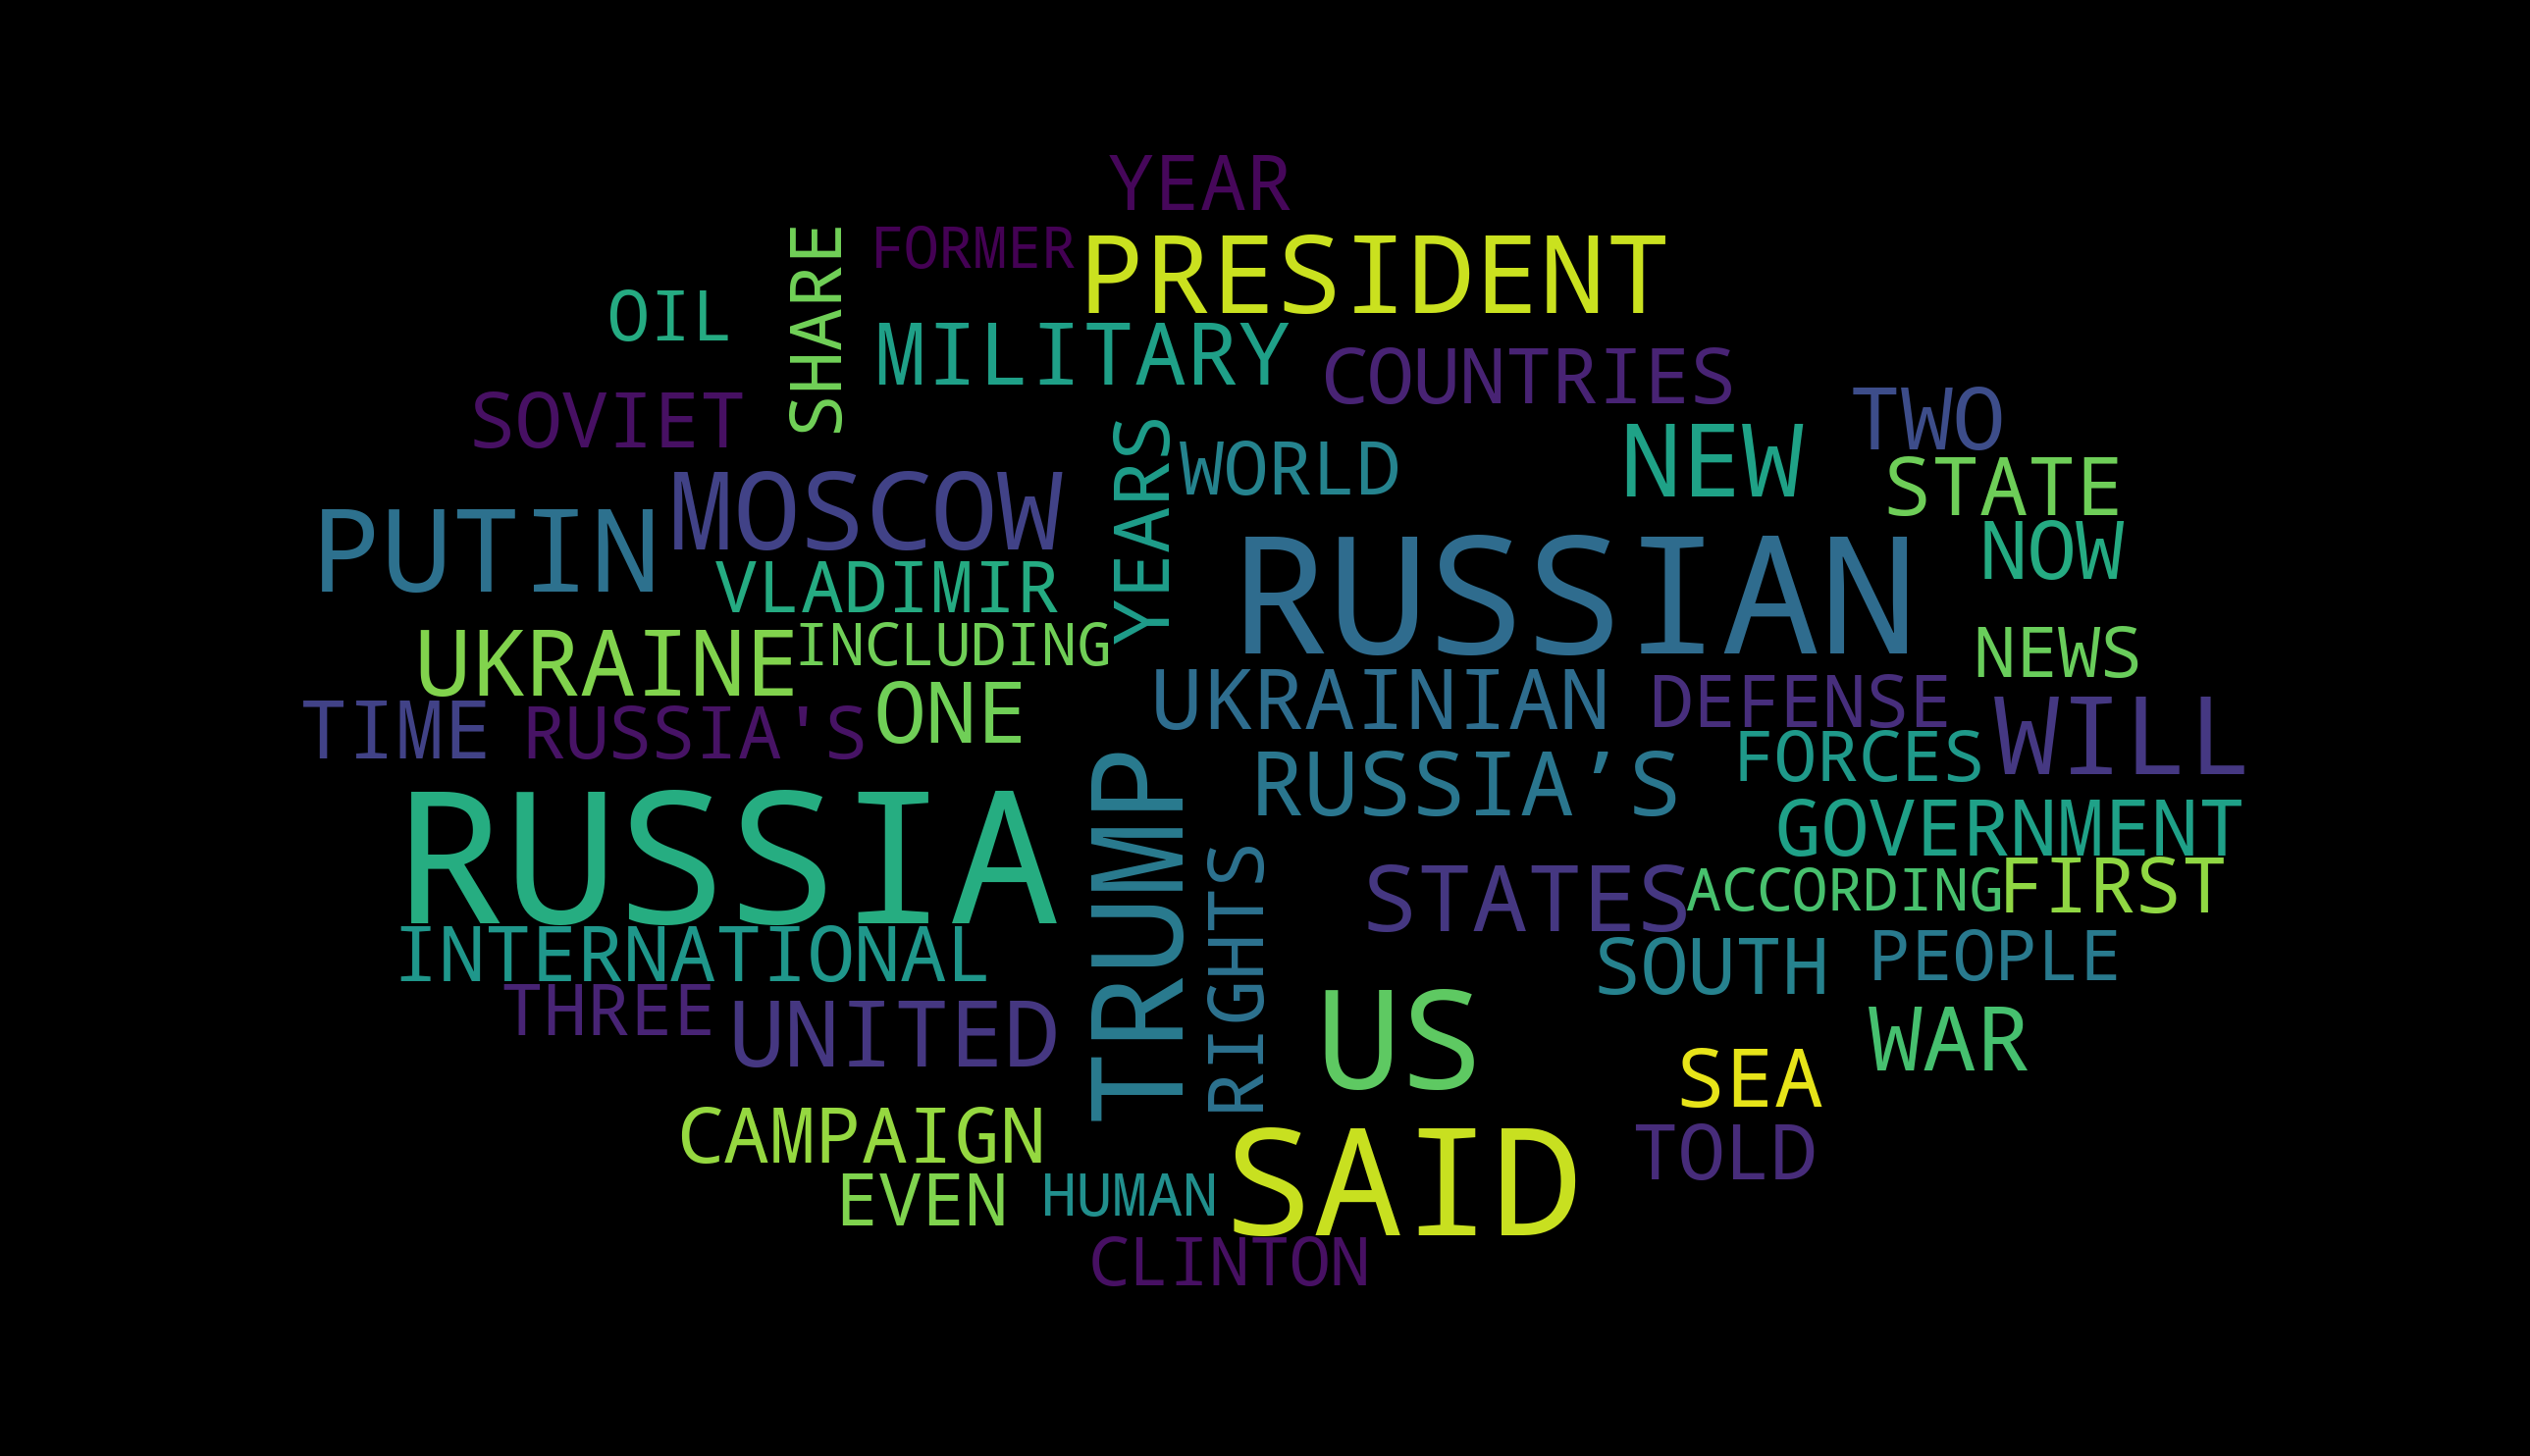

In [12]:
mask = np.array(Image.open("oval.png"))    # маска, внутри которой необходимо расположить слова
wordcloud = WordCloud(max_words=50, background_color='black', 
                      mode="RGBA", mask=mask).fit_words(word_freq_dict)    # формируем объект WorldCloud
wordcloud.to_file("result.png")    # сохраняем WordCloud в файл
Image.open("result.png")    # открываем сохраненный файл